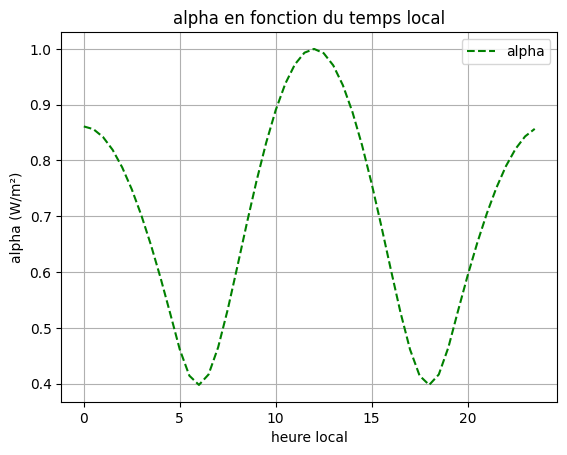

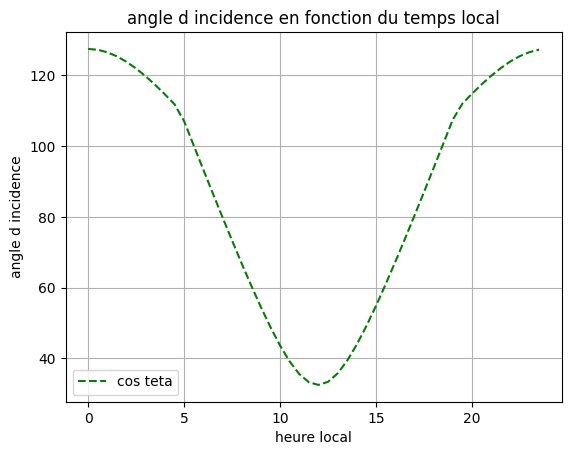

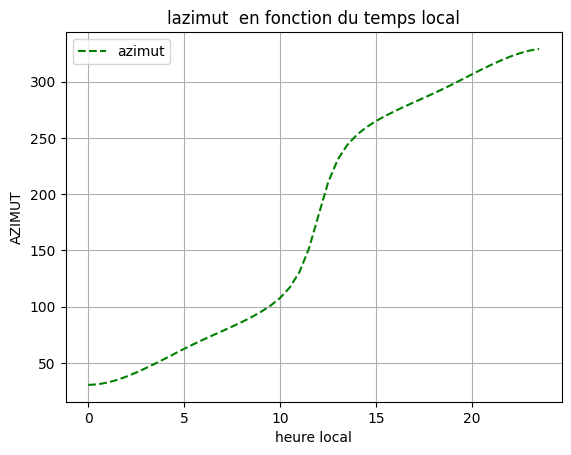

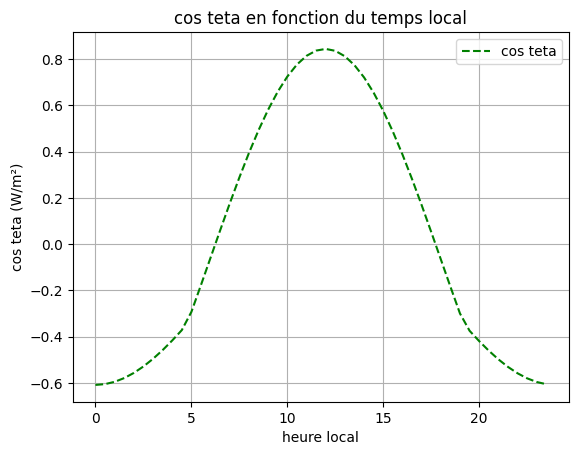

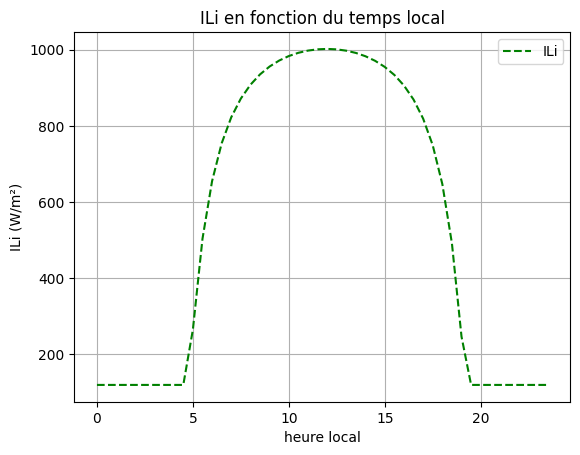

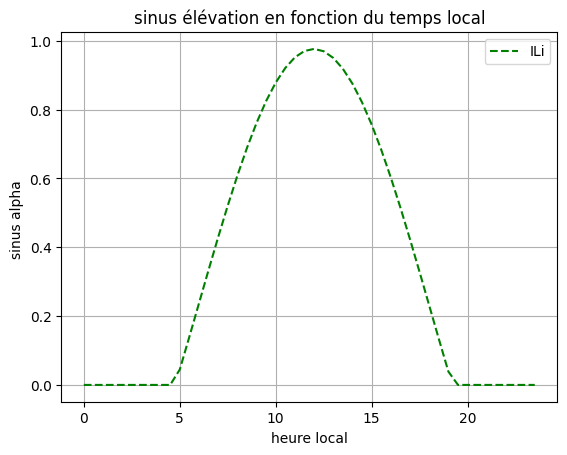

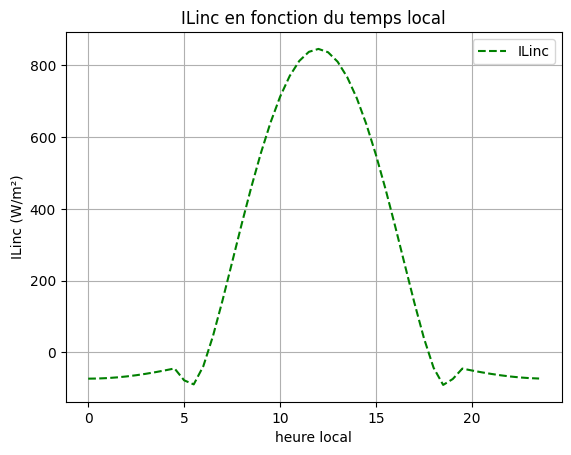

/tmp/ipython-input-4098689136.py:106: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(ILinc, heures)


np.float64(2439.1436657076542)

In [1]:
from re import I

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound

def calcul_numero_jour(Nm, Njm):
    y = (Nm - 1) * 30 + Njm
    return y

def calcul_angle_B(Nj):
    B = np.radians(0.98563 * (Nj - 173))
    return B

def equation_du_temps(Nj):
    x = 360 * (Nj - 1) / 365.242
    EOT = (0.258 * np.cos(np.radians(x))
           - 7.416 * np.sin(np.radians(x))
           - 3.648 * np.cos(2 * np.radians(x))
           - 9.228 * np.sin(2 * np.radians(x)))
    return EOT

def calcul_TSV(heures, longitude_locale, longitude_fuseau, EOT):

    LC = (longitude_locale - longitude_fuseau) / 15
    TSV = heures - (EOT / 60) + LC
    return TSV

def calcul_angle_horaire(TSV):
    w=np.radians(15 * (TSV - 12))
    return w


def calcul_declinaison(B):
    decl=np.arcsin(0.39795 * np.cos(B))
    return decl

def calcul_elevation(decl, latitude_locale, w):
    alpha = np.arcsin(np.sin(decl) * np.sin(latitude_locale) +
                      np.cos(decl) * np.cos(latitude_locale) * np.cos(w))
    # Si alpha est une valeur négative, la remplacer par 0
    # Use np.where to replace negative values with 0 element-wise
    alpha = np.where(alpha < 0, 0, alpha)
    return alpha

def calcul_azimut(w,decl,alpha,latitude_locale):
  A=np.zeros(len(w))
  A1=np.zeros(len(w))
  for i in range (len(w)):
    A[i]=np.arccos((np.sin(decl)*np.cos(latitude_locale)-np.cos(decl)*np.cos(w[i])*np.sin(latitude_locale))/(np.cos(alpha[i])))
    if np.sin(w[i])>=0:
      A1[i]=2*np.pi-A[i]
    else:
      A1[i]=A[i]
  return A1


def calcul_A_he(y):
    return np.sin(np.radians((360 / 365) * (y - 121)))


def calcul_T0(latitude_locale, A_he, z, alpha):

    alpha = np.array(alpha)
    t00 = 2.4 - 0.9 * np.sin(latitude_locale) + 0.1 * (2 + np.sin(latitude_locale)) * A_he - 0.2 * z - (1.22 + 0.14 * A_he) * (1 - np.sin(alpha))


    return t00

def calcul_T1(z):
    return (0.89) ** z

def calcul_T2(A_he, z):
    return (0.9 + 0.4 * A_he) * (0.63) ** z




def I_L(I_0, alpha, Tl, z):
    alpha=np.array(alpha)
    expterme=np.exp(-Tl * (1 / (0.9 + (9.4 / (0.89 ** z)) * np.sin(alpha))))
    IL=I_0*expterme
    return IL


def _cos_teta(alpha, beta, gamma, A):
    return np.sin(alpha) * np.cos(beta) + np.cos(alpha) * np.sin(beta) * np.cos((gamma - A))




#ILi intensité incidente
def ILi(I_0, Tl, z,alpha):
  alpha=np.array(alpha)
  return I_0 * np.exp(-Tl * (1 / (0.9 + (9.4 / (0.89 ** z)) * np.sin(alpha))))



#Intensité lumineuse sur un plan incliné
def _ILinc(ILi, cos_teta):

    return ILi* cos_teta


def integrale_ILi_trapz(heures, ILinc):
    return np.trapz(ILinc, heures)


#Calcul du rendement annuel
def rendement_annuel(latitude_locale, longitude_locale, longitude_fuseau, z, I_0,beta,gamma):
    somme = 0

    for j in range(366):
        heuress = np.arange(0, 24, 0.5)

        b = calcul_angle_B(j)
        eot = equation_du_temps(j)
        tsv = calcul_TSV(heuress, longitude_locale, longitude_fuseau, eot)
        wi = calcul_angle_horaire(tsv)
        decli = calcul_declinaison(b)
        alphai = calcul_elevation(decli, latitude_locale, wi)
        Ai = calcul_azimut(wi, decli, alphai,latitude_locale)
        cos_tetaiii = _cos_teta(alphai, beta, gamma, Ai)
        t00 = calcul_T0(latitude_locale, calcul_A_he(j), z, alphai)
        t11 = calcul_T1(z)
        t22 = calcul_T2(calcul_A_he(j), z)
        tli = t00 + t11 + t22
        ili = I_L(I_0, alphai, tli, z)
        iilinc = _ILinc(ili, cos_tetaiii)

        somme += integrale_ILi_trapz(heuress, iilinc)

    return somme / 1000


def max_beta(alpha, gamma, A):
  beta=np.zeros(len(alpha))
  for i in range(len(alpha)):
    beta[i] = np.arctan2(np.cos(alpha[i]) * np.cos(gamma- A[i]), np.sin(alpha[i]))
    beta[i] = beta[i] % (2 * np.pi)

  return beta






# Programme principal
Nm=6
Njm = 21
longitude_locale = np.radians(10.1815)  # En degrés
latitude_locale = np.radians(36)  # En degrés
longitude_fuseau = np.radians(15)  # En degrés (UTC+1)

I_0 = 1367  # Intensité initiale (exemple)
z = 1  # Exemple de valeur pour z
beta = np.radians(45)
gamma = np.radians(180)


y = calcul_numero_jour(Nm, Njm)  #nombre du jour de l'année
heures = np.arange(0, 24, 0.5)
EOT = equation_du_temps(y)
TSV = calcul_TSV(heures, longitude_locale, longitude_fuseau, EOT)
w=calcul_angle_horaire(TSV)
decl=calcul_declinaison(calcul_angle_B(y))

alpha=calcul_elevation(decl, latitude_locale, w)

A = calcul_azimut(w,decl,alpha,latitude_locale)

# Calcul de Tl
A_he = calcul_A_he(y)
T0 = calcul_T0(latitude_locale, A_he, z, alpha)
T1 = calcul_T1(z)
T2= calcul_T2(A_he, z)
Tl=T0+T1+T2

IL=I_L(I_0, alpha, Tl, z)

ILi=ILi(I_0, Tl, z,alpha)

cos_teta=_cos_teta(alpha, beta, gamma, A)

ILinc=_ILinc(ILi, cos_teta)

nouv_beta=max_beta(alpha, gamma, A)
opt=_cos_teta(alpha, nouv_beta, gamma, A)

#representation des courbes


plt.figure()
plt.plot(heures,opt, label='alpha', color='green', linestyle='dashed')
plt.title('alpha en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('alpha (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(heures,np.degrees(np.arccos(cos_teta)), label='cos teta', color='green', linestyle='dashed')
plt.title('angle d incidence en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('angle d incidence')
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(heures,np.degrees(A), label='azimut', color='green', linestyle='dashed')
plt.title('lazimut  en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('AZIMUT')
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(heures,cos_teta, label='cos teta', color='green', linestyle='dashed')
plt.title('cos teta en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('cos teta (W/m²)')
plt.legend()
plt.grid()
plt.show()


plt.figure()
plt.plot(heures,ILi, label='ILi', color='green', linestyle='dashed')
plt.title('ILi en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('ILi (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(heures,np.sin(alpha), label='ILi', color='green', linestyle='dashed')
plt.title('sinus élévation en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('sinus alpha ')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(heures,ILinc, label='ILinc', color='green', linestyle='dashed')
plt.title('ILinc en fonction du temps local')
plt.xlabel('heure local')
plt.ylabel('ILinc (W/m²)')
plt.legend()
plt.grid()
plt.show()

rendement_annuel(latitude_locale, longitude_locale, longitude_fuseau, z, I_0,beta,gamma)
rendement_annuel(latitude_locale, longitude_locale, longitude_fuseau, z, I_0,nouv_beta,gamma)